# **Background**
In research & news articles, keywords form an important component since they provide a concise representation of the article’s content. Keywords also play a crucial role in locating the article from information retrieval systems, bibliographic databases and for search engine optimization. Keywords also help to categorize the article into the relevant subject or discipline.
Conventional approaches of extracting keywords involve manual assignment of keywords based on the article content and the authors’ judgment. This involves a lot of time & effort and also may not be accurate in terms of selecting the appropriate keywords. With the emergence of Natural Language Processing (NLP), keyword extraction has evolved into being effective as well as efficient.
And in this article, we will combine the two — we’ll be applying NLP on a collection of articles (more on this below) to extract keywords.

# About the dataset
In this article, we will be extracting keywords from a dataset that contains about 3,800 abstracts. The original dataset is from Kaggle — NIPS Paper. Neural Information Processing Systems (NIPS) is one of the top machine learning conferences in the world. This dataset includes the title and abstracts for all NIPS papers to date (ranging from the first 1987 conference to the current 2016 conference).
The original dataset also contains the article text. However, since the focus is on understanding the concept of keyword extraction and using the full article text could be computationally intensive, only abstracts have been used for NLP modelling. The same code block can be used on the full article text to get a better and enhanced keyword extraction.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nips-papers/paper_authors.csv
/kaggle/input/nips-papers/papers.csv
/kaggle/input/nips-papers/authors.csv
/kaggle/input/nips-papers/database.sqlite


# **Importing the dataset**
The dataset used for this article is a subset of the papers.csv dataset provided in the NIPS paper datasets on Kaggle. Only those rows that contain an abstract have been used. The title and abstract have been concatenated after which the file is saved as a tab separated *.txt file.

In [2]:
import pandas
# load the dataset
dataset = pandas.read_csv('/kaggle/input/nips-papers/papers.csv')
dataset.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


# **Preliminary text exploration**
Before we proceed with any text pre-processing, let's quickly explore the dataset in terms of word counts, most common and most uncommon words.

# **Fetch word count for each abstract**

In [3]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['title'].apply(lambda x: len(str(x).split(" ")))
dataset[['title','word_count']].head()

,title,word_count
0,Self-Organization of Associative Database and ...,7
1,A Mean Field Theory of Layer IV of Visual Cort...,17
2,Storing Covariance by the Associative Long-Ter...,15
3,Bayesian Query Construction for Neural Network...,7
4,"Neural Network Ensembles, Cross Validation, an...",8


The average word count is about 156 words per abstract. The word count ranges from a minimum of 27 to a maximum of 325. The word count is important to give us an indication of the size of the dataset that we are handling as well as the variation in word counts across the rows.

In [4]:
##Descriptive statistics of word counts
dataset.word_count.describe()

count    7241.000000
mean        7.619390
std         2.802944
min         1.000000
25%         6.000000
50%         7.000000
75%         9.000000
max        20.000000
Name: word_count, dtype: float64

In [5]:
#Identify common words
freq = pandas.Series(' '.join(dataset['title']).split()).value_counts()[:20]
freq

for         2036
of          1819
Learning    1417
and         1284
in          1054
with         970
the          733
A            715
Neural       565
to           529
Networks     520
a            445
Models       397
Model        327
Bayesian     286
from         262
Using        260
on           249
by           240
Network      230
dtype: int64

In [6]:
#Identify uncommon words
freq1 =  pandas.Series(' '.join(dataset 
         ['title']).split()).value_counts()[-20:]
freq1

Submultiplicative     1
Isometric             1
Privacy-preserving    1
Reservoirs            1
third-order           1
Auto-Annotation       1
Chick                 1
Preserves             1
Memoizer              1
NCA                   1
integrate-and-fire    1
rationality           1
hyperpriors           1
Inside/Outside        1
Occular               1
Constant-Time         1
copulas               1
Also                  1
Extractions           1
Wiener                1
dtype: int64

In [7]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "inversely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: invers
lemmatization: inversely


In [8]:
# Libraries for text preprocessing
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

In [9]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [10]:
corpus = []
for i in range(0, 3847):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['title'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [11]:
#View corpus item
corpus[222]

'combining neural network regression estimate regularized linear weight'

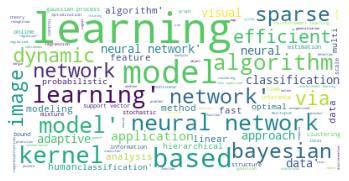

In [12]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [14]:
list(cv.vocabulary_.keys())[:10]

['self',
 'organization',
 'associative',
 'database',
 'application',
 'self organization',
 'organization associative',
 'organization associative database',
 'mean',
 'field']

[Text(0, 0, 'learning'),
 Text(1, 0, 'model'),
 Text(2, 0, 'network'),
 Text(3, 0, 'neural'),
 Text(4, 0, 'algorithm'),
 Text(5, 0, 'kernel'),
 Text(6, 0, 'bayesian'),
 Text(7, 0, 'based'),
 Text(8, 0, 'analysis'),
 Text(9, 0, 'data'),
 Text(10, 0, 'process'),
 Text(11, 0, 'classification'),
 Text(12, 0, 'image'),
 Text(13, 0, 'gaussian'),
 Text(14, 0, 'inference'),
 Text(15, 0, 'dynamic'),
 Text(16, 0, 'multi'),
 Text(17, 0, 'sparse'),
 Text(18, 0, 'recognition'),
 Text(19, 0, 'feature')]

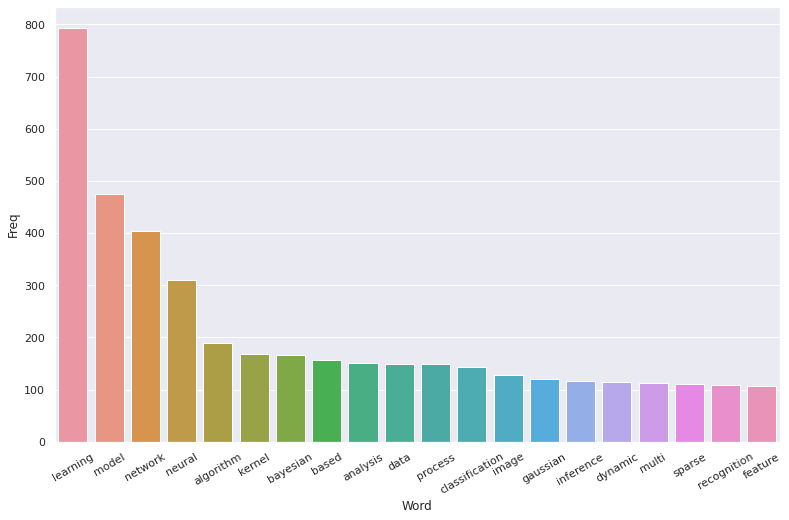

In [15]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pandas.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                   Bi-gram  Freq
0           neural network   195
1   reinforcement learning    86
2         gaussian process    80
3           support vector    57
4           vector machine    43
5          semi supervised    40
6       component analysis    35
7          graphical model    32
8          active learning    29
9      supervised learning    29
10          spiking neuron    29
11      speech recognition    27
12        high dimensional    26
13             monte carlo    24
14             analog vlsi    24
15               real time    22
16            markov model    22
17          bayesian model    22
18      belief propagation    22
19            random field    22


[Text(0, 0, 'neural network'),
 Text(1, 0, 'reinforcement learning'),
 Text(2, 0, 'gaussian process'),
 Text(3, 0, 'support vector'),
 Text(4, 0, 'vector machine'),
 Text(5, 0, 'semi supervised'),
 Text(6, 0, 'component analysis'),
 Text(7, 0, 'graphical model'),
 Text(8, 0, 'active learning'),
 Text(9, 0, 'supervised learning'),
 Text(10, 0, 'spiking neuron'),
 Text(11, 0, 'speech recognition'),
 Text(12, 0, 'high dimensional'),
 Text(13, 0, 'monte carlo'),
 Text(14, 0, 'analog vlsi'),
 Text(15, 0, 'real time'),
 Text(16, 0, 'markov model'),
 Text(17, 0, 'bayesian model'),
 Text(18, 0, 'belief propagation'),
 Text(19, 0, 'random field')]

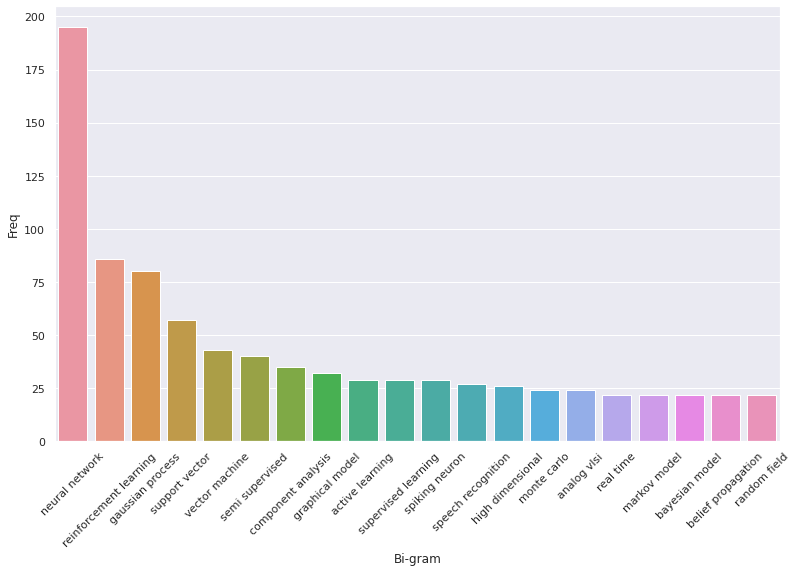

In [16]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pandas.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                          Tri-gram  Freq
0           support vector machine    37
1         semi supervised learning    22
2         recurrent neural network    16
3   independent component analysis    16
4              hidden markov model    16
5      gaussian process regression    15
6          markov decision process    13
7            radial basis function    11
8            latent variable model    10
9     principal component analysis    10
10          spike timing dependent    10
11     latent dirichlet allocation    10
12        multiple kernel learning    10
13            neural network model     9
14             multi task learning     9
15     timing dependent plasticity     9
16        conditional random field     9
17             markov random field     9
18             vlsi neural network     8
19        dynamic bayesian network     8


[Text(0, 0, 'support vector machine'),
 Text(1, 0, 'semi supervised learning'),
 Text(2, 0, 'recurrent neural network'),
 Text(3, 0, 'independent component analysis'),
 Text(4, 0, 'hidden markov model'),
 Text(5, 0, 'gaussian process regression'),
 Text(6, 0, 'markov decision process'),
 Text(7, 0, 'radial basis function'),
 Text(8, 0, 'latent variable model'),
 Text(9, 0, 'principal component analysis'),
 Text(10, 0, 'spike timing dependent'),
 Text(11, 0, 'latent dirichlet allocation'),
 Text(12, 0, 'multiple kernel learning'),
 Text(13, 0, 'neural network model'),
 Text(14, 0, 'multi task learning'),
 Text(15, 0, 'timing dependent plasticity'),
 Text(16, 0, 'conditional random field'),
 Text(17, 0, 'markov random field'),
 Text(18, 0, 'vlsi neural network'),
 Text(19, 0, 'dynamic bayesian network')]

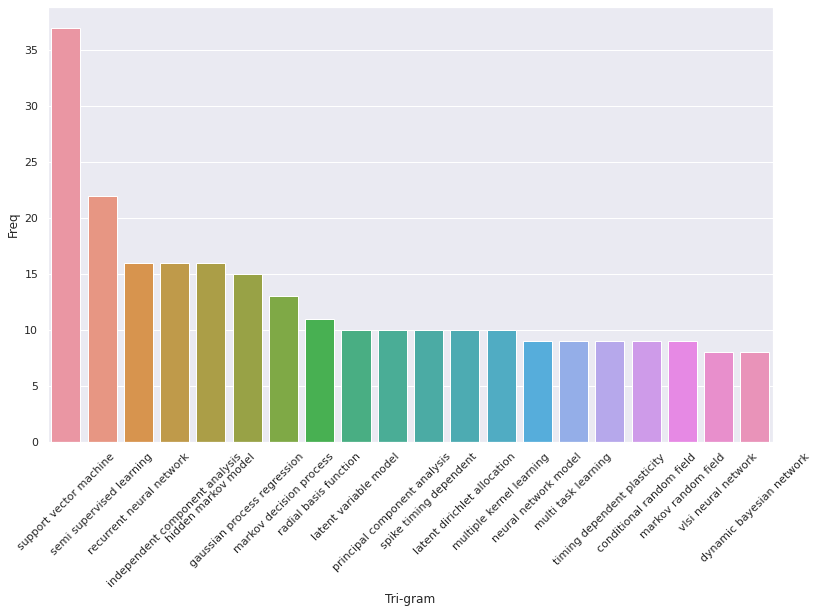

In [17]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pandas.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[532]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [19]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
reinforcement learning algorithm partially observable environment short term memory

Keywords:
observable environment short 0.277
algorithm partially observable 0.264
algorithm partially 0.264
reinforcement learning algorithm 0.255
partially observable environment 0.255


Ideally for the IDF calculation to be effective, it should be based on a large corpora and a good representative of the text for which the keywords need to be extracted. In our example, if we use the full article text instead of the abstracts, the IDF extraction would be much more effective. However, considering the size of the dataset, I have limited the corpora to just the abstracts for the purpose of demonstration.
This is a fairly simple approach to understand fundamental concepts of NLP and to provide a good hands-on practice with some python codes on a real-life use case. The same approach can be used to extract keywords from news feeds & social media feeds.